### SW installation instructions

To follow this notebook you must be able to run Jupyter notebooks on your PC as well as have installed version 0.19 of scikit-learn and 2.1 of keras.

The simplest way of doing so is to download and install the Miniconda distribution and then use the command `conda install` to add the `ìpython, scikit-learn` and `keras` packages.

A convenient alternative for Windows is the WinPython distribution https://winpython.github.io/.

# Optimization on NNs

1. Batch vs minibatch: lbfgs vs adam in sklearn
2. Performance of keras optimizers
3. DNNs do not overfit: train vs validation in keras

## 1. Batch vs minibatch: lbfgs vs adam in sklearn

We will work with the housing dataset obtained from sklearn.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

from sklearn.datasets import load_boston

In [3]:
boston_data = load_boston()

df_housing = pd.DataFrame(data=boston_data['data'], columns=boston_data['feature_names'])
df_housing['MEDV'] = boston_data['target']

vars   = df_housing.columns[ : -1]
target = df_housing.columns[-1]

std_sc = StandardScaler()

x = std_sc.fit_transform( df_housing[ vars ].values )
y = df_housing[ target ].values

n_patterns, dim = x.shape

In [4]:
hidden_layer_sizes = (40, 20)
alpha_S = 100.
tol = y.std() * 1.e-6

mlp_s =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                      alpha=alpha_S,
                      activation='relu', 
                      solver='lbfgs', 
                      #batch_size=batch_size,
                      tol=tol, 
                      max_iter=10000,
                      early_stopping=False)

t0 = time.time()
mlp_s.fit(x, y)
t1 = time.time()

In [5]:
print("lbfgs_iters \t%d" % mlp_s.n_iter_)
print("lbfgs_loss  \t%.3f" % mlp_s.loss_)
print("train_time  \t%.4f" % (t1-t0))

y_pred = mlp_s.predict(x)
print("lbfgs_test_loss: %.3f" % (mean_squared_error(y, y_pred)))

lbfgs_iters 	1593
lbfgs_loss  	6.010
train_time  	6.4480
lbfgs_test_loss: 5.335


In [6]:
batch_size = n_patterns
batch_size = 200
tol = y.var() * 1.e-6

mlp_s =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                      alpha=alpha_S,
                      activation='relu', 
                      solver='adam', 
                      #nesterovs_momentum=False,
                      batch_size=batch_size,
                      tol=tol*1.e-3, 
                      max_iter=20000,
                      early_stopping=False)

t0 = time.time()
mlp_s.fit(x, y)
t1 = time.time()

In [7]:
print("adam_iters \t%d" % mlp_s.n_iter_)
print("adam_loss  \t%.3f" % mlp_s.loss_)
print("train_time \t%.4f" % (t1-t0))

y_pred = mlp_s.predict(x)
print("adam_test_loss: %.3f" % (mean_squared_error(y, y_pred)))

adam_iters 	675
adam_loss  	11.952
train_time 	6.7628
adam_test_loss: 11.777


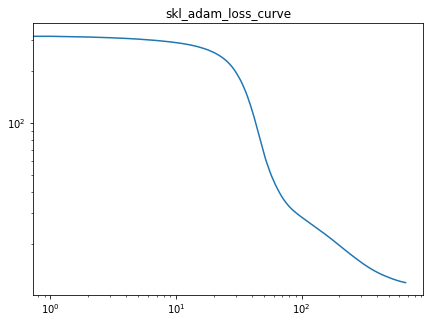

In [8]:
plt.figure( figsize=(7,5))
plt.title("skl_adam_loss_curve")
plt.xscale('log')
plt.yscale('log')
_ = plt.plot(mlp_s.loss_curve_)

## 2. Performance of keras optimizers

3. DNNs do not overfit: train vs validation in keras


In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Nadam, Adamax
from keras.callbacks import EarlyStopping, History

import keras.backend as K

C:\Users\Usuario\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
alpha_K = alpha_S/n_patterns/2.

# input
main_input = Input(shape=(dim, ))

# layers
z = main_input
for i, num_hidden in enumerate(hidden_layer_sizes):
    layer = Dense(num_hidden, kernel_initializer="he_uniform", 
                  activation='relu', 
                  kernel_regularizer=l2(alpha_K))
                  #kernel_regularizer=l2(alpha))
    z = layer(z)

# output    
ls_layer = Dense(units=1,
                 activation='linear', 
                 #kernel_initializer="glorot_uniform", 
                 kernel_initializer="he_uniform", 
                 kernel_regularizer=l2(alpha_K),
                 name='ls_output')
ls_output = ls_layer(z)

# compile
mlp_k = Model(inputs=[main_input], outputs=[ls_output])

print(mlp_k.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                560       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
ls_output (Dense)            (None, 1)                 21        
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

tol = y.var() * 1.e-6            
callbacks = [History(), 
             EarlyStopping(monitor='loss',
                    min_delta=tol, 
                    patience=10)
            ]        
d_h = {}
for k, optimizer in enumerate([Adadelta(), Adagrad(), Adam(), Nadam()]):
    t0 = time.time()
    reset_weights(mlp_k)
    mlp_k.compile(optimizer=optimizer, loss={'ls_output': 'mean_squared_error'})
    mlp_k.fit(x, y, 
              epochs=10000,
              batch_size=batch_size,
              callbacks=callbacks,
              shuffle=True,
              verbose=0)
    t1 = time.time()    
    
    d_h[k] = mlp_k.history.history['loss']
    
    print("\n", optimizer)
    print("\titers \t%d" % len(mlp_k.history.history['loss']))
    print("\tloss  \t%.3f" % mlp_k.history.history['loss'][-1])
    print("\ttest_loss  \t%.3f" % mlp_k.evaluate(x, y, verbose=0))
    print("\ttrain_time \t%.4f" % (t1-t0))


	iters 	578
	loss  	11.406
	test_loss  	11.253
	train_time 	14.3335

	iters 	6391
	loss  	12.430
	test_loss  	12.420
	train_time 	90.1231

	iters 	1839
	loss  	9.702
	test_loss  	9.674
	train_time 	27.5457

	iters 	776
	loss  	10.395
	test_loss  	10.522
	train_time 	15.0947


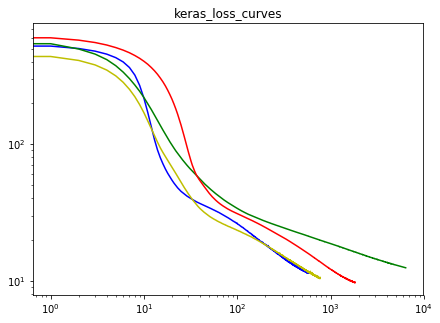

In [12]:
plt.figure( figsize=(7,5))
plt.title("keras_loss_curves")

l_colors = ['b', 'g', 'r', 'y']
for k, c in zip( d_h.keys(), l_colors):
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(d_h[k], color=c)

## 3. DNNs do not overfit: train vs validation in keras

In [13]:
idx = np.array(range(n_patterns))

np.random.shuffle(idx) 

idx_1 = idx[ : n_patterns//2]
idx_2 = idx[n_patterns//2 : ]
x_1 = x[idx_1, : ]
y_1 = y[idx_1]

x_2 = x[idx_2, : ]
y_2 = y[idx_2]

reset_weights(mlp_k)
mlp_k.compile(optimizer=Adam(), loss={'ls_output': 'mean_squared_error'})
mlp_k.fit(x_1, y_1, 
              epochs=10000,
              #batch_size=batch_size,
              batch_size=50,
              callbacks=callbacks,
              shuffle=True,
              validation_data=[x_2, y_2], 
              verbose=0)

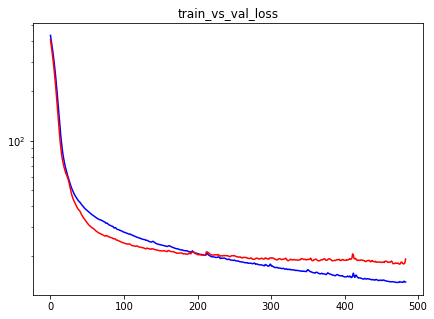

In [14]:
plt.figure( figsize=(7,5))
plt.title("train_vs_val_loss")

#plt.xscale('log')
plt.yscale('log')

_ = plt.plot(mlp_k.history.history['loss'], 'b', mlp_k.history.history['val_loss'], 'r')